# Stroke Prediction

## Import Libraries

In [ ]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# datasets path and df names
path = [
    '/content/drive/My Drive/SVM/demographic.csv',
    '/content/drive/My Drive/SVM/examination.csv',
    '/content/drive/My Drive/SVM/questionnaire.csv',
    '/content/drive/My Drive/SVM/labs.csv',
    '/content/drive/My Drive/SVM/diet.csv'
]

dfname = [
    'dm',
    'exam',
    'qs',
    'lab',
    'diet'
]

In [ ]:
# import datasets as dfs

df = {}
dfn = dict(zip(dfname, path))
df = {key: pd.read_csv(value) for key, value in dfn.items()}

## Data Cleaning

In [ ]:
Xs = {k: v for k, v in df.items() if k in ['dm', 'exam', 'labs']}

dfs = Xs.values()

from functools import partial, reduce
inner_merge = partial(pd.merge, how='inner', on='SEQN')

c = reduce(inner_merge, dfs)
c

# check if there are duplicated SEQN
c.SEQN.duplicated().value_counts()

SEQN
False    9813
Name: count, dtype: int64

In [ ]:
# show combined df
qs = df['qs'][['SEQN','MCQ160F']]
qs

,SEQN,MCQ160F
0,73557,1.0
1,73558,2.0
2,73559,2.0
3,73560,NaN
4,73561,2.0
...,...,...
10170,83727,2.0
10171,83728,NaN
10172,83729,2.0
10173,83730,NaN


In [ ]:
c = pd.merge(c,qs, how='left', on='SEQN')
c

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,CSXSOAOD,CSXGRAOD,CSXONOD,CSXNGSOD,CSXSLTRT,CSXSLTRG,CSXNART,CSXNARG,CSAEFFRT,MCQ160F
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,1.0,1.0,1.0,4.0,62.0,1.0,NaN,NaN,1.0,1.0
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,1.0,2.0,3.0,4.0,28.0,1.0,NaN,NaN,1.0,2.0
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,1.0,2.0,3.0,4.0,49.0,1.0,NaN,NaN,3.0,2.0
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,1.0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9808,83727,8,2,1,26,NaN,2,2,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
9809,83728,8,2,2,2,24.0,1,1,2.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9810,83729,8,2,2,42,NaN,4,4,2.0,NaN,...,1.0,1.0,3.0,4.0,55.0,1.0,NaN,NaN,3.0,2.0
9811,83730,8,2,1,7,NaN,2,2,1.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
c.MCQ160F.value_counts()

MCQ160F
2.0    5389
1.0     194
9.0       5
Name: count, dtype: int64

In [ ]:
# MCQ160F (target feature): exclude null values and NA
c = c[(c.MCQ160F.notnull()) & (c.MCQ160F != 9)]

# check MCQ160F
c.MCQ160F.describe()

count    5583.000000
mean        1.965252
std         0.183158
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: MCQ160F, dtype: float64

In [ ]:
# target varoable counts
c.MCQ160F.value_counts()

MCQ160F
2.0    5389
1.0     194
Name: count, dtype: int64

### code book
https://www.kaggle.com/lcchennn/nhanes-2013-2014-codebook-with-sas-label

In [ ]:
# import code book
cbook = pd.read_csv('/content/drive/My Drive/SVM/nhanes_2013_2014_codebook.csv')

cbook

,variable,label
0,SEQN,Respondent sequence number
1,SDDSRVYR,Data release cycle
2,RIDSTATR,Interview/Examination status
3,RIAGENDR,Gender
4,RIDAGEYR,Age in years at screening
...,...,...
3901,WHD140,Self-reported greatest weight (pounds)
3902,WHQ150,Age when heaviest weight
3903,WHQ030M,How do you consider your weight
3904,WHQ500,Trying to do about weight


## Data Cleaning

In [ ]:
# exclude non-numeric values
d = c.select_dtypes(['number'])

# exclue columns that have over 50% NaN
d = d.dropna(thresh = 0.5*len(d), axis =1)

print(len(d.columns), 'columns left')

153 columns left


In [ ]:
# changing target variable coding from 1, 2 to 0 (Negative), 1 (Positive)
d['MCQ160F']=d.apply(lambda x: 1 if x.MCQ160F == 1 else 0, axis='columns')
d.MCQ160F.value_counts()

MCQ160F
0    5389
1     194
Name: count, dtype: int64

## Feature Selection

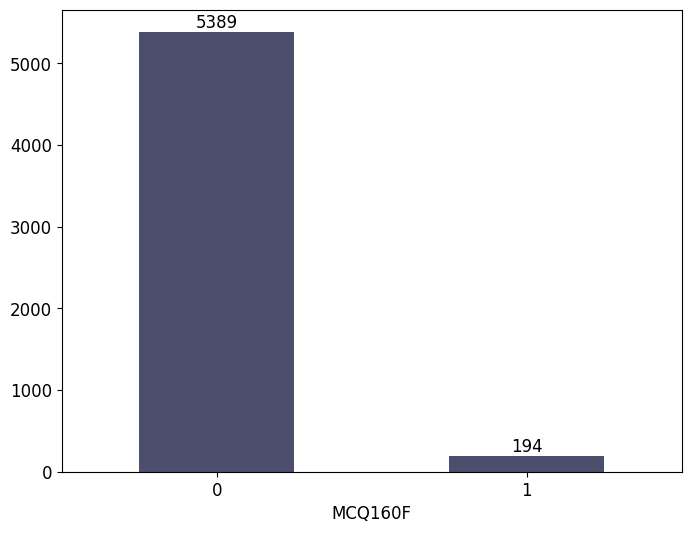

In [ ]:
vals = d.MCQ160F.value_counts()

plt.figure(figsize=(8,6))
plt.rc('font', size=12)

ax = vals.plot.bar(rot=0, color='#4B4E6D')

for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [ ]:
from sklearn.impute import SimpleImputer
imp_mode=SimpleImputer(strategy='most_frequent')

d = pd.DataFrame(imp_mode.fit_transform(d), columns=d.columns)

In [ ]:
X = d.loc[:, d.columns != 'MCQ160F']
y = d.MCQ160F

In [ ]:
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (5583, 152)
y shape: (5583,)


## Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

## SVM Model

In [70]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

svm_clf = SVC(kernel='rbf', gamma='auto', random_state=11, probability=True)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)
mscore=[]
mscore.append(['SVM', svm_clf.score(X_test, y_test)])


print('Classification Report:')
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

Accuracy Score: 0.963294538943599
Prediction: [0. 0. 0. ... 0. 0. 0.]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98      1076
         1.0       0.00      0.00      0.00        41

    accuracy                           0.96      1117
   macro avg       0.48      0.50      0.49      1117
weighted avg       0.93      0.96      0.95      1117

Confusion Matrix:
[[1076    0]
 [  41    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ROC Chart

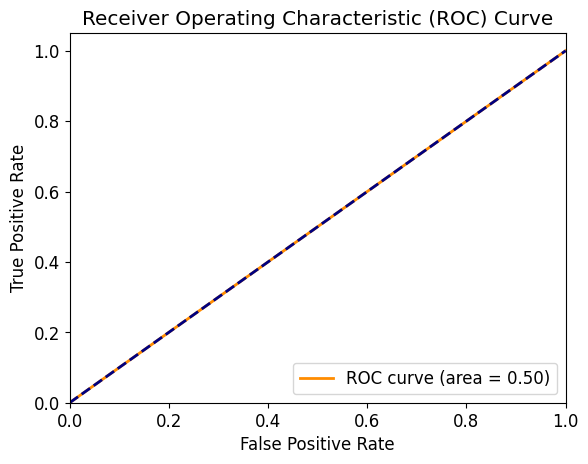

In [82]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()